# Sentiment Analysis Prototyping

Prototype code for ML-based sentiment analysis.

In [1]:
import os, re, string

import numpy as np
import pandas as pd

import nltk
nltk.data.path.append("../data/external/nltk_data")
from nltk import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23

## Loading

In [3]:
data_path = "/mnt/DATA/NRW2019 Dropbox/data 4good/CSVData"
fpath = os.path.join(data_path, "TestData", "forSentAnalysis.csv")

labeled_data = pd.read_csv(fpath)
labeled_data.shape

(1056, 7)

Rating schema: {0: "positive", 10: "neutral", 20: "negative", 30: "offensive", -2: "notAssessable"}

## Preprocessing

Dataset cleansing

In [4]:
# Remove unnecessary cols and rename columns uniformly
labeled_data.drop(["id", "Level", "Topic", "sentiment"], axis=1, inplace=True)
labeled_data.columns = ["source", "text", "rating"]

# Remove not assessable texts
labeled_data = labeled_data[labeled_data.rating != -2]

labeled_data.shape

(869, 3)

Text cleansing

In [5]:
def clean_text(text):
    """ Util: Cleans text string.
    > Lowercase string
    > Replace game scores with "GAME_SCORE" placeholder
    > Punctuation removal
    > Replace numbers with "NUM" placeholder
    """
    lowercased = text.lower()
    scores_removed = re.sub(r"(\d+) ?(-|:) ?(\d+)", "GAME_SCORE ", lowercased)
    punctuations = string.punctuation + "„" + "”"
    punct_removed = scores_removed.translate(str.maketrans("", "",
                                                           punctuations))
    num_replaced = re.sub(r"\b\d+\b", "NUM", punct_removed)

    return num_replaced

labeled_data["cleaned_txt"] = labeled_data.text.apply(clean_text)

## Exploration

NaN Stats

In [6]:
labeled_data.isna().sum()

source         0
text           0
rating         0
cleaned_txt    0
dtype: int64

Distribution of sources

In [7]:
print("Sources count:", len(labeled_data.source.value_counts()))
print("Avg count of doc per source:", np.mean(labeled_data.source.value_counts().tolist()))
print("Top 5 sources:")
labeled_data.source.value_counts()[:5]

Sources count: 49
Avg count of doc per source: 17.73469387755102
Top 5 sources:


DIE_KRONE                 111
JOY_PAMELA_RENDIWAGNER    111
FLORIAN_KLENK              95
DER_STANDARD               71
KURIER                     56
Name: source, dtype: int64

Distribution of ratings

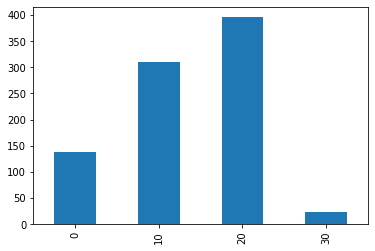

In [8]:
labeled_data.rating.value_counts(sort=False).plot(kind="bar")

-> we have imbalanced data. As detecting offensive texts is not the prime target of this Sentiment Classifier, lets go with it as it is for the moment and evaluate the results. Maybe we have to upsample positive and offensive texts later, if performance and generalization is bad.

## Sentiment Assignment

ML-based approach.

### Train/Test-Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.cleaned_txt, labeled_data.rating,
                                                    test_size=0.15, random_state=random_state)

print("X shapes (train/test):", X_train.shape, "/", X_test.shape)
print("y shapes (train/test):", y_train.shape, "/", y_test.shape)

X shapes (train/test): (738,) / (131,)
y shapes (train/test): (738,) / (131,)


### Vectorizer

In [10]:
tfidf = TfidfVectorizer(lowercase=False, # already lowercased
                        tokenizer=word_tokenize) 
                        # maybe def max_features

### Models

In [11]:
logreg = LogisticRegression()
svc = LinearSVC()
nb = MultinomialNB()
rf = RandomForestClassifier()

models = [logreg, svc, nb, rf]

### Pipeline

In [12]:
classifiers = {}

for model in models:
    classifiers[type(model).__name__ + "_pipe"] = Pipeline([
        ("tfidf", tfidf),
        ("clf", model)
    ])

Train

In [13]:
for _, clf_pipeline in classifiers.items():
    clf_pipeline.fit(X_train, y_train)

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predict

In [14]:
for name, clf_pipeline in classifiers.items():
    y_pred = clf_pipeline.predict(X_test)
    print(name, ":")
    print(classification_report(y_test, y_pred))

LogisticRegression_pipe :
              precision    recall  f1-score   support

           0       0.50      0.05      0.10        19
          10       0.42      0.19      0.26        52
          20       0.40      0.75      0.53        56
          30       1.00      0.25      0.40         4

    accuracy                           0.41       131
   macro avg       0.58      0.31      0.32       131
weighted avg       0.44      0.41      0.35       131

LinearSVC_pipe :
              precision    recall  f1-score   support

           0       0.40      0.21      0.28        19
          10       0.44      0.33      0.37        52
          20       0.43      0.62      0.51        56
          30       1.00      0.25      0.40         4

    accuracy                           0.44       131
   macro avg       0.57      0.35      0.39       131
weighted avg       0.45      0.44      0.42       131

MultinomialNB_pipe :
              precision    recall  f1-score   support

           

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Parameter Tuning

In [15]:
#TODO

## Evaluation

In [16]:
class_encoding = {0: "positive", 10: "neutral", 20: "negative", 30: "offensive"}

#### Confusion Matrix

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


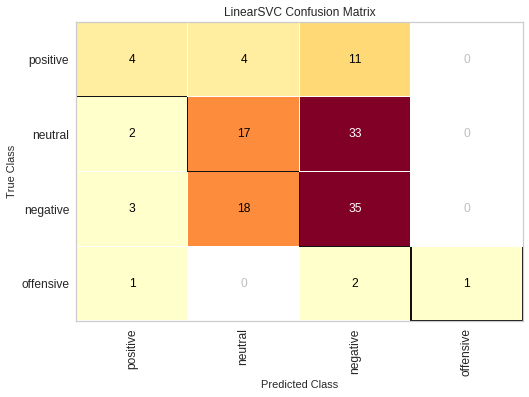

In [17]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, PrecisionRecallCurve, ROCAUC

cm = ConfusionMatrix(classifiers["LinearSVC_pipe"], is_fitted=True, encoder=class_encoding)
cm.score(X_test, y_test)
cm.poof()

#### Classification Report

              precision    recall  f1-score   support

           0       0.25      0.11      0.15        19
          10       0.42      0.31      0.36        52
          20       0.42      0.62      0.50        56
          30       1.00      0.25      0.40         4

    accuracy                           0.41       131
   macro avg       0.52      0.32      0.35       131
weighted avg       0.41      0.41      0.39       131



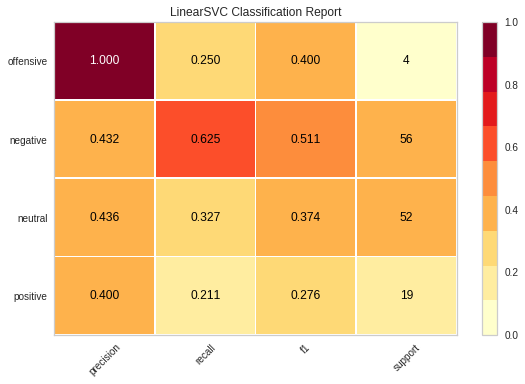

In [18]:
print(classification_report(y_test, y_pred))

# Visualizer
report = ClassificationReport(classifiers["LinearSVC_pipe"], is_fitted=True, encoder=class_encoding, support=True)
report.score(X_test, y_test)
report.poof()

#### Precision-Recall Curve

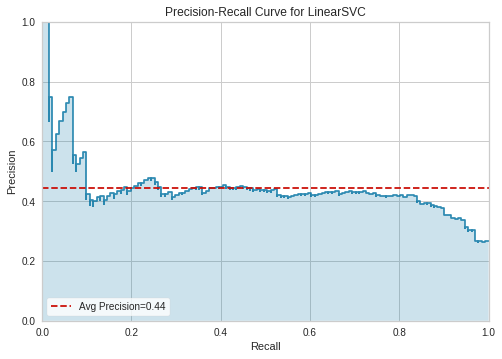

In [19]:
pr_curve = PrecisionRecallCurve(classifiers["LinearSVC_pipe"])
pr_curve.fit(X_train, y_train)
pr_curve.score(X_test, y_test)
pr_curve.poof()

#### ROCAUC

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


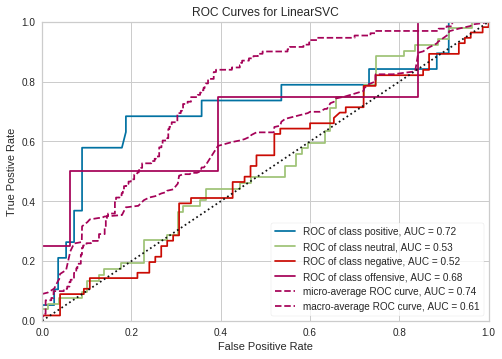

In [20]:
rocauc = ROCAUC(classifiers["LinearSVC_pipe"], is_fitted=True, encoder=class_encoding)
rocauc.score(X_test, y_test)
rocauc.poof()

# Conclusion

#FIXME